In [1]:
import torch
from model.model_3D import *
from model.train_eval import *
import copy
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import h5py
import os
from postprocessing.save_results import *
from postprocessing.plot_results import *
from postprocessing.metrics import single_roc_curve
from pathlib import Path
import pandas as pd
from matplotlib.patches import Patch

In [2]:
### check if cuda is available

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using {device}.")

Using cuda.


In [3]:
### import data

def load_with_hdf5(name):
    """
    Load tensor data from HDF5 with gzip compression
    """
    with h5py.File(f"data/{name}.h5", "r") as f:
        loaded_features = torch.from_numpy(f["features"][:])
        loaded_labels = torch.from_numpy(f["labels"][:])
    return TensorDataset(loaded_features, loaded_labels)

train_set = load_with_hdf5("train_set_ndvi_v7")
val_set = load_with_hdf5("val_set_ndvi_v7")
test_set = load_with_hdf5("test_set_ndvi_v7")


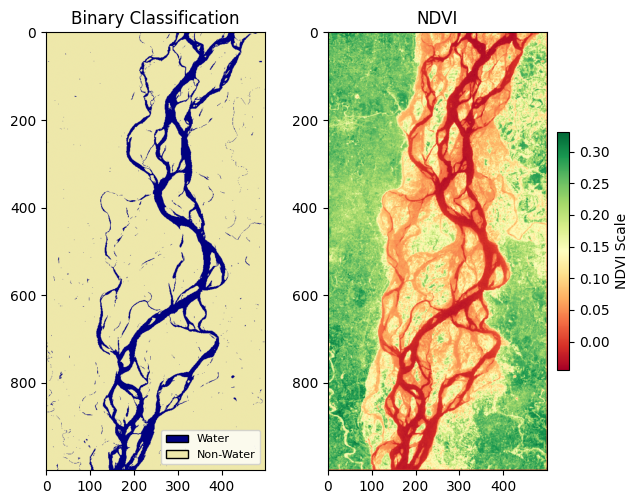

In [4]:
sample_no = 15
example_image_channel1 = train_set.tensors[0][sample_no, 0, 1, :, :]
example_image_channel2 = train_set.tensors[0][sample_no, 1, 1, :, :]

# Define the custom colormap for the binary classification
grey_cmap = ListedColormap(['palegoldenrod', 'navy'])

# Plot the example images
fig, ax = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'wspace': 0.1})  # Reduced space between plots

# Binary Classification Image
binary_img = ax[0].imshow(example_image_channel1, cmap=grey_cmap)
ax[0].set_title('Binary Classification')

# Add a legend for Binary Classification in the bottom-left (inside the plot)
legend_elements_1 = [
    Patch(facecolor='navy', edgecolor='black', label='Water'),
    Patch(facecolor='palegoldenrod', edgecolor='black', label='Non-Water')
]
ax[0].legend(
    handles=legend_elements_1,
    loc='lower left',
    bbox_to_anchor=(0.5, 0.001),  # Slight offset to avoid the axis,
    fontsize=8
)

# NDVI Image
ndvi_img = ax[1].imshow(example_image_channel2, cmap='RdYlGn')
ax[1].set_title('NDVI')

# Add a color bar for NDVI
cbar = fig.colorbar(ndvi_img, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('NDVI Scale')

# Adjust layout and spacing
# plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust space to make room for the legend

svg_path = "images/binary_ndvi_plot.svg"
# plt.savefig(svg_path, format='svg', bbox_inches='tight')


plt.show()

In [5]:
# Convert the PyTorch tensors to NumPy arrays for processing
image1_np = example_image_channel1.numpy()  # Binary classification image
image2_np = example_image_channel2.numpy()  # NDVI image

# Optionally, create an overlay combining both images
overlay_np = (image1_np * 0.5) + (image2_np * 0.5)  # Example of overlay


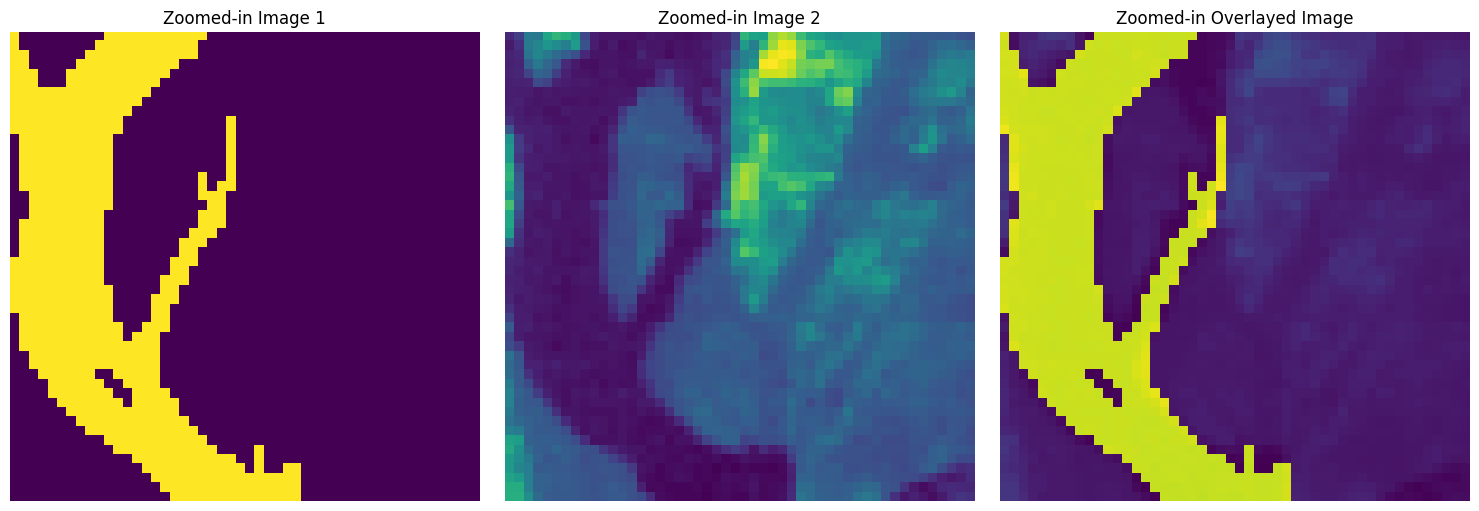

In [6]:
# Define the region of interest (zoom coordinates)
start_row, end_row = 250, 300  # Adjust as needed
start_col, end_col = 250, 300  # Adjust as needed

# Crop the zoomed region from all images
zoomed_image1 = image1_np[start_row:end_row, start_col:end_col]
zoomed_image2 = image2_np[start_row:end_row, start_col:end_col]
zoomed_overlay = overlay_np[start_row:end_row, start_col:end_col]

# Plot the zoomed-in regions for all three images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Zoomed-in Original Image 1
axs[0].imshow(zoomed_image1, cmap="viridis")
axs[0].set_title("Zoomed-in Image 1")
axs[0].axis("off")

# Zoomed-in Original Image 2
axs[1].imshow(zoomed_image2, cmap="viridis")
axs[1].set_title("Zoomed-in Image 2")
axs[1].axis("off")

# Zoomed-in Overlayed Image
axs[2].imshow(zoomed_overlay, cmap="viridis")
axs[2].set_title("Zoomed-in Overlayed Image")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [7]:
# Load model

model_filename = f"model/models_trained/UNet3D_machine_1_NDVI_bs16_lr0.01_hid8_epoch50.pth"


n_channels = train_set[0][0].shape[0]
n_classes = 1 # ?
init_hid_dim = 8
kernel_size = 3
pooling = 'max'

#initialize model
model = UNet3D(n_channels=n_channels,
               n_classes=n_classes,
               init_hid_dim=init_hid_dim,
               kernel_size=kernel_size,
               pooling=pooling,
               bilinear=False,
               drop_channels=False)

# Load model state dictionary
model.load_state_dict(torch.load(model_filename))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Model loaded successfully!")


Model loaded successfully!


In [8]:
# Load losses and metrics
# losses_file = "metrics_and_losses/spatial_1_hid8_kernel3_max_lr0.05_step15_gamma0.75_bs16_epochs10_wt0.5_losses.csv"

# df_losses = pd.read_csv(losses_file)


# print("Losses loaded successfully!")

metrics_file = "model/losses_metrics/machine_1_losses_metrics_NDVI_bs16_lr0.01_hid8_epoch50.csv"

df_metrics = pd.read_csv(metrics_file)
train_losses = df_metrics["Training loss"].tolist()
val_losses = df_metrics["Validation loss"].tolist()
accuracies = df_metrics["Accuracy"].tolist()
precisions = df_metrics["Precision"].tolist()
recalls = df_metrics["Recall"].tolist()
f1_scores = df_metrics["F1-score"].tolist()
csi_scores = df_metrics["CSI-score"].tolist()

metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]
print("Metrics loaded successfully!")

Metrics loaded successfully!


ATTENTION: the argument `save_name` is not specified: the plot is not saved.


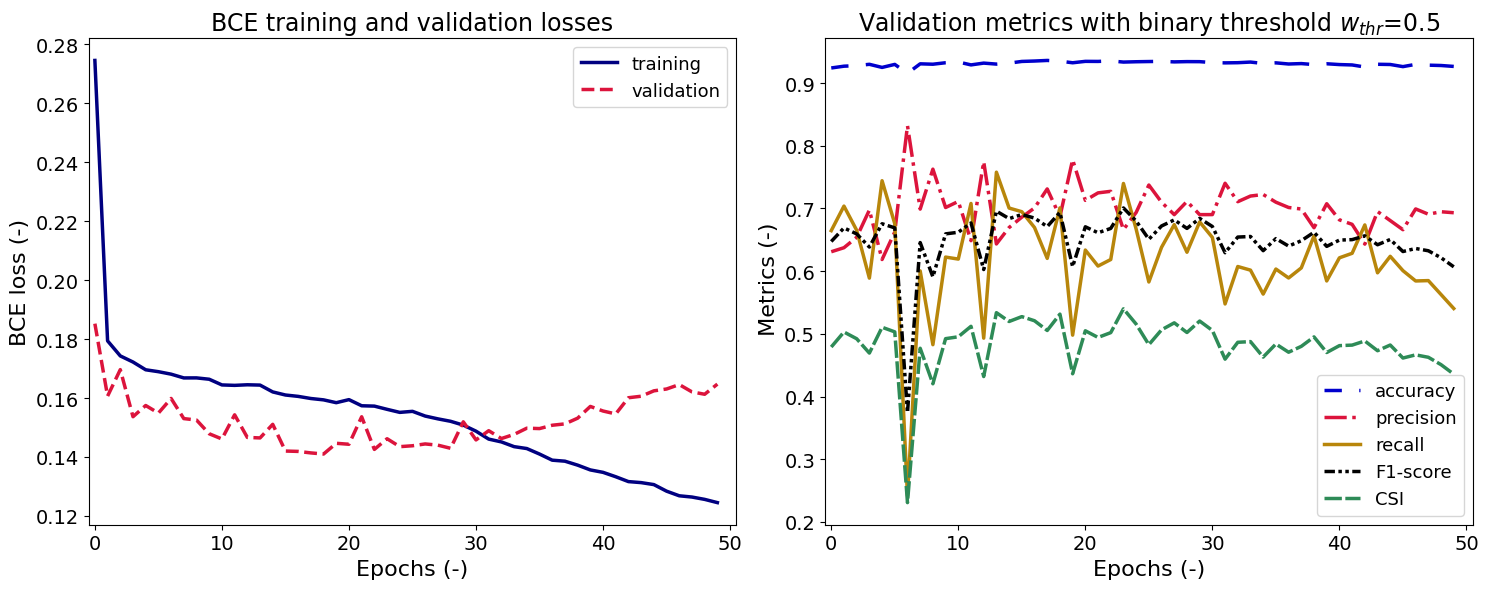

In [9]:
plot_losses_metrics(train_losses, val_losses, metrics, model, loss_f="BCE")

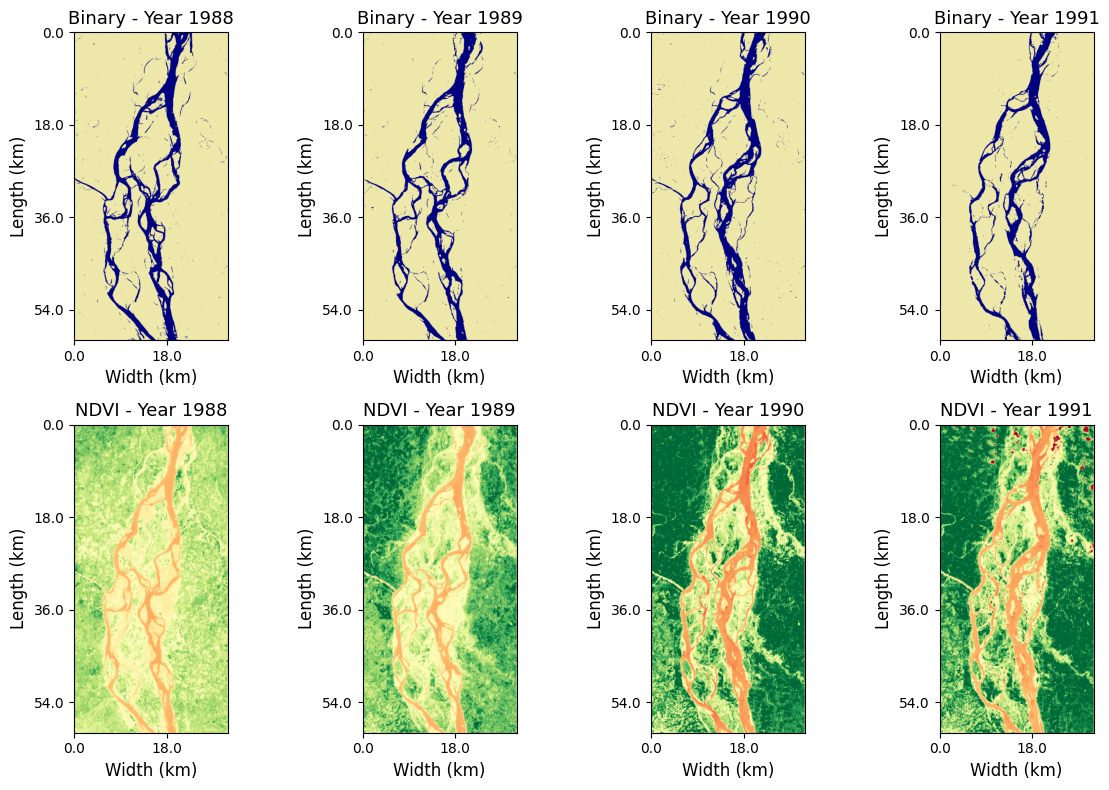

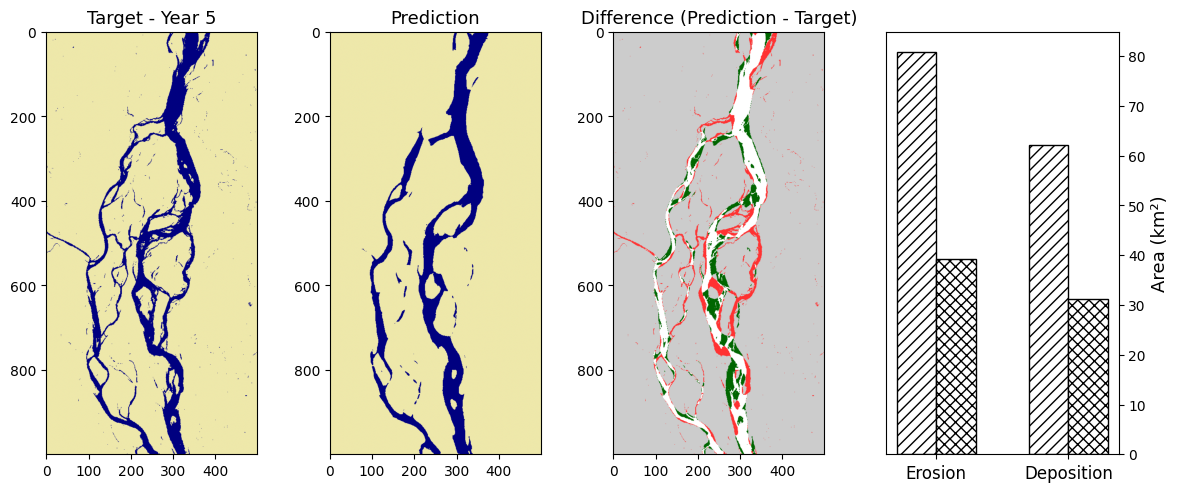

In [10]:
sample_index = 11 # Example test sample index
show_evolution_nolegend_3d(sample_index, test_set, model)

In [11]:
def show_results_3d(sample_img, dataset, model, water_threshold=0.5, device='cuda:0', save_img=False, title=None):
    """
    Visualize the target, prediction, and misclassification map with an optional title.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import ListedColormap

    # Ensure the input has the correct shape (N, C, T, H, W)
    input_img = dataset[sample_img][0].unsqueeze(0).to(device)  # Add batch dimension
    target_img = dataset[sample_img][1].cpu()

    # Get model prediction
    with torch.no_grad():
        prediction = model(input_img).detach().cpu()  # Shape: (N, C, H, W)

    # Binary thresholding
    prediction_binary = (prediction >= water_threshold).float()

    # Calculate misclassification map
    diff = prediction_binary.squeeze(0).squeeze(0) - target_img  # Remove batch and channel dims

    # Set up figure
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Custom colormaps
    grey_cmap = ListedColormap(['palegoldenrod', 'navy'])  # For binary river images
    diff_cmap = ListedColormap(['red', 'white', 'green'])
    grey_diff_cmap = ListedColormap(['black', 'white'])

    # Plot target
    ax[0].imshow(target_img, cmap=grey_cmap, vmin=0)
    ax[0].set_title('Target', fontsize=13)
    ax[0].set_xlabel('Width (km)', fontsize=12)
    ax[0].set_ylabel('Length (km)', fontsize=12)

    # Plot prediction
    ax[1].imshow(prediction_binary.squeeze(0).squeeze(0), cmap=grey_cmap)
    ax[1].set_title('Prediction', fontsize=13)
    ax[1].set_xlabel('Width (km)', fontsize=12)

    # Plot misclassification map
    ax[2].imshow(diff, cmap=diff_cmap, vmin=-1, vmax=1)
    ax[2].imshow(target_img, cmap=grey_diff_cmap, vmin=0, alpha=0.2)
    ax[2].set_title('Difference (Prediction - Target)', fontsize=13)
    ax[2].set_xlabel('Width (km)', fontsize=12)

    # Add optional title for the entire figure
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')

    # Adjust layout
    fig.subplots_adjust(wspace=0.3, top=0.85 if title else 0.9)
    plt.tight_layout()

    # Save or show the plot
    if save_img:
        plt.savefig(f'output_{sample_img}.png', bbox_inches='tight', dpi=1000)
        plt.close(fig)
    else:
        plt.show()

    return None


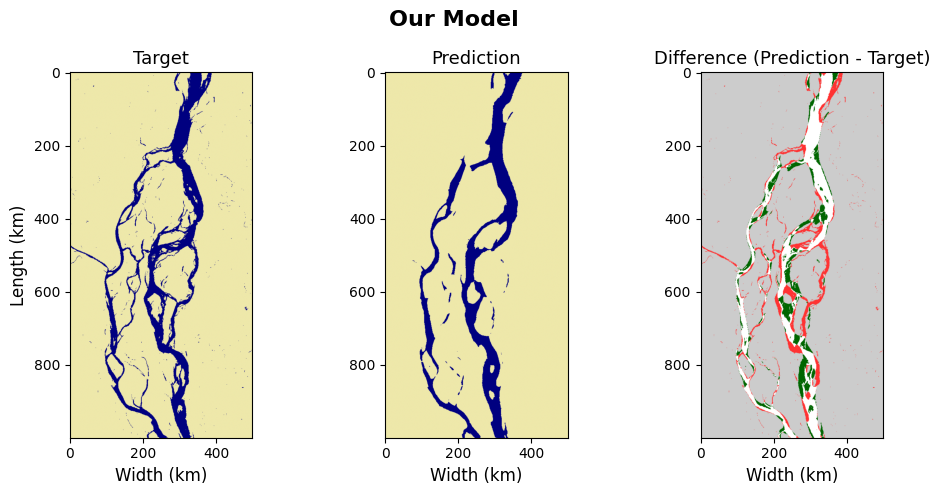

In [12]:
sample_index = 11 # Example test sample index
show_results_3d(sample_index, test_set, model, title="Our Model")

In [13]:
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import ListedColormap
# from PIL import Image

# def create_gif_all_samples(dataset, model, water_threshold=0.5, device='cuda:0', output_gif='output_all_samples.gif', title=None):
#     """
#     Create a GIF visualizing the target, prediction, and misclassification map for all samples in the dataset
#     with transparent plot backgrounds.
#     """
#     # Directory to store temporary frames
#     frame_dir = "frames"
#     os.makedirs(frame_dir, exist_ok=True)

#     # Custom colormaps
#     grey_cmap = ListedColormap(['palegoldenrod', 'navy'])  # For binary river images
#     diff_cmap = ListedColormap(['red', 'white', 'green'])
#     grey_diff_cmap = ListedColormap(['black', 'white'])

#     # Generate frames for all samples
#     frame_paths = []
#     for sample_idx in range(len(dataset)):
#         # Extract the data for the current sample
#         input_img = dataset[sample_idx][0].unsqueeze(0).to(device)  # Shape: (1, C, T, H, W)
#         target_img = dataset[sample_idx][1].cpu()  # Shape: (H, W)

#         with torch.no_grad():
#             prediction = model(input_img).detach().cpu()  # Shape: (1, C, H, W)

#         # Binary thresholding
#         prediction_binary = (prediction >= water_threshold).float()
#         diff = prediction_binary.squeeze(0).squeeze(0) - target_img  # Misclassification map

#         # Plot the current sample
#         fig, ax = plt.subplots(1, 3, figsize=(8, 5))
        
#         # Make the figure background transparent
#         fig.patch.set_alpha(0)

#         ax[0].imshow(target_img, cmap=grey_cmap, vmin=0)
#         ax[0].set_title('Target', fontsize=13)
#         ax[0].axis('off')  # Hide axes

#         ax[1].imshow(prediction_binary.squeeze(0).squeeze(0), cmap=grey_cmap)
#         ax[1].set_title('Prediction', fontsize=13)
#         ax[1].axis('off')  # Hide axes

#         ax[2].imshow(diff, cmap=diff_cmap, vmin=-1, vmax=1)
#         ax[2].imshow(target_img, cmap=grey_diff_cmap, vmin=0, alpha=0.2)
#         ax[2].set_title('Difference', fontsize=13)
#         ax[2].axis('off')  # Hide axes

#         # Add title for the entire figure
#         if title:
#             fig.suptitle(f"{title} - Sample {sample_idx}", fontsize=16, fontweight='bold', color='black')

#         # Save frame with transparent background
#         frame_path = os.path.join(frame_dir, f"frame_{sample_idx}.png")
#         plt.savefig(frame_path, bbox_inches='tight', dpi=300, transparent=True)
#         frame_paths.append(frame_path)
#         plt.close(fig)

#     # Create GIF
#     frames = [Image.open(frame).convert("RGBA") for frame in frame_paths]
#     frames[0].save(
#         output_gif,
#         save_all=True,
#         append_images=frames[1:],
#         duration=500,  # 500 ms per frame (2 FPS)
#         loop=0
#     )

#     # Cleanup temporary files
#     for frame_path in frame_paths:
#         os.remove(frame_path)
#     os.rmdir(frame_dir)

#     print(f"GIF saved to {output_gif}")

# create_gif_all_samples(
#     dataset=test_set,
#     model=model,
#     water_threshold=0.5,
#     device='cuda:0',
#     output_gif="all_samples_transparent_background.gif",
# )



In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the CSV files
csv_dir = "model/losses_metrics"

# Specify files to plot and their labels
files_to_plot = [
    "Antonio_UNet3D_spatial_losses&metrics_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.csv",
    "machine_1_losses_metrics_NDVI_bs16_lr0.01_hid8_epoch50.csv",
]

labels = [
    "Antonio's Model",
    "Our Model",
]

# Colors for each model
colors = {
    "Antonio's Model": "red",
    "Our Model": "blue",
}

# Load losses
training_losses = {}
validation_losses = {}
max_epochs = 0  # Track the maximum number of epochs

for file_name, label in zip(files_to_plot, labels):
    file_path = os.path.join(csv_dir, file_name)
    df = pd.read_csv(file_path)
    # Take only the first 50 epochs for Antonio's model
    if "Antonio" in label:
        validation_losses[label] = df["Validation loss"][:50].tolist()
        training_losses[label] = df["Training loss"][:50].tolist()
    else:
        validation_losses[label] = df["Validation loss"].tolist()
        training_losses[label] = df["Training loss"].tolist()
    max_epochs = max(max_epochs, len(validation_losses[label]))

# Directory to store temporary frames
frame_dir = "loss_frames"
os.makedirs(frame_dir, exist_ok=True)

# Generate frames
frame_paths = []
for epoch in range(1, max_epochs + 1):
    # Create the figure
    fig, ax = plt.subplots(figsize=(9, 6))
    # fig.patch.set_alpha(0)  # Make the figure background transparent

    # Plot training and validation losses up to the current epoch
    for label in labels:
        ax.plot(range(epoch), validation_losses[label][:epoch], label=f"{label} (Validation)", color=colors[label], linestyle='-')
        ax.plot(range(epoch), training_losses[label][:epoch], label=f"{label} (Training)", color=colors[label], linestyle='--')

    # Customize plot appearance
    ax.set_xlim(0, max_epochs)
    ax.set_ylim(0.12, max(max(max(val) for val in validation_losses.values()), max(max(train) for train in training_losses.values())))
    ax.set_xlabel("Epoch", fontsize=16, weight='bold')
    ax.set_ylabel("BCE Loss", fontsize=16, weight='bold')
    ax.set_title("Training and Validation Loss Comparison", fontsize=18, weight='bold')
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Save the frame with a transparent background only around the titles
    frame_path = os.path.join(frame_dir, f"frame_{epoch:03d}.png")
    plt.savefig(frame_path, bbox_inches="tight", dpi=600, transparent=True)
    frame_paths.append(frame_path)
    plt.close(fig)

# Create the GIF
frames = [Image.open(frame).convert("RGBA") for frame in frame_paths]
output_gif = "losses_animation.gif"
frames[0].save(
    output_gif,
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration of each frame in ms
    loop=0
)

# Clean up temporary frames
for frame_path in frame_paths:
    os.remove(frame_path)
os.rmdir(frame_dir)

print(f"GIF saved to {output_gif}")


GIF saved to losses_animation.gif


/workspace/aiaiaik-ramba/postprocessing/metrics.py:189: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/workspace/aiaiaik-ramba/postprocessing/metrics.py:189: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


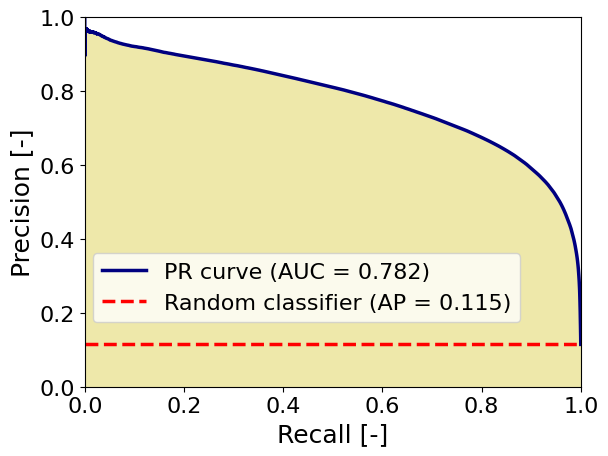

In [15]:
get_total_pr_curve(model, test_set)

In [15]:
# Load the CSV file
file_path = 'results_hyper_opt.csv'
df = pd.read_csv(file_path)

# Find the row with the lowest test loss
best_model_row = df.loc[df['Test Loss'].idxmin()]

# Extract relevant metrics for the best model
best_model_info = best_model_row[['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test CSI Score']]

# Print the metrics
print("Metrics for the Best Model (Lowest Test Loss):")
print(f"Test Loss:         {best_model_info['Test Loss']:.3f}")
print(f"Test Accuracy:     {best_model_info['Test Accuracy']:.3f}")
print(f"Test Precision:    {best_model_info['Test Precision']:.3f}")
print(f"Test Recall:       {best_model_info['Test Recall']:.3f}")
print(f"Test F1 Score:     {best_model_info['Test F1 Score']:.3f}")
print(f"Test CSI Score:    {best_model_info['Test CSI Score']:.3f}")


Metrics for the Best Model (Lowest Test Loss):
Test Loss:         0.138
Test Accuracy:     0.937
Test Precision:    0.715
Test Recall:       0.746
Test F1 Score:     0.730
Test CSI Score:    0.575


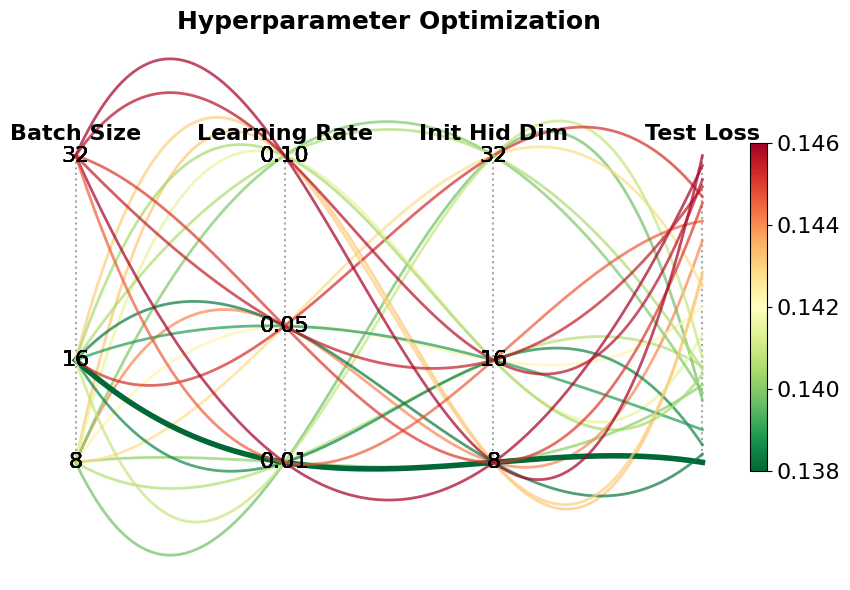

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import make_interp_spline

# Load the dataset
file_path = 'results_hyper_opt.csv'
data = pd.read_csv(file_path)

# Select relevant columns for the parallel coordinates plot
columns_of_interest = ['Batch Size', 'Learning Rate', 'Init Hid Dim', 'Test Loss']
df = data[columns_of_interest]

# Normalize Test Loss for coloring
norm = Normalize(vmin=np.round(df['Test Loss'].min(), 3), vmax=np.round(df['Test Loss'].max(), 3))
colormap = cm.RdYlGn_r

# Identify the chosen model (lowest Test Loss and matching parameters)
chosen_model = df[(df['Batch Size'] == 16) & 
                  (df['Learning Rate'] == 0.01) & 
                  (df['Init Hid Dim'] == 8)].iloc[0]

# Create the plot
fig, ax = plt.subplots(figsize=(9, 6))

# Create separate axes for each hyperparameter and normalize them
num_columns = len(columns_of_interest)
x_positions = np.linspace(0, 1, num_columns)  # Evenly spaced x positions for axes
normalized_data = {}

for i, col in enumerate(columns_of_interest):
    col_min, col_max = df[col].min(), df[col].max()
    normalized_data[col] = (df[col] - col_min) / (col_max - col_min)  # Normalize each column
    ax.vlines(x_positions[i], 0, 1, color='gray', linestyle='dotted', alpha=0.7)  # Draw axes
    ax.text(x_positions[i], 1.05, col, fontsize=16, ha='center', color='black', weight='bold')  # Label axes

# Generate smooth lines for each sample
for idx, row in df.iterrows():
    y_values = [normalized_data[col].iloc[idx] for col in columns_of_interest]
    actual_values = [row[col] for col in columns_of_interest[:-1]]  # Exclude Test Loss for annotations
    # Smooth interpolation
    x_smooth = np.linspace(x_positions.min(), x_positions.max(), 300)
    y_smooth = make_interp_spline(x_positions, y_values, k=3)(x_smooth)
    color = colormap(norm(row['Test Loss']))

    # Highlight the chosen model by making its line thicker
    if (row['Batch Size'] == chosen_model['Batch Size'] and
        row['Learning Rate'] == chosen_model['Learning Rate'] and
        row['Init Hid Dim'] == chosen_model['Init Hid Dim']):
        ax.plot(x_smooth, y_smooth, alpha=1.0, linewidth=4, color=color, label="Chosen Model")
    else:
        ax.plot(x_smooth, y_smooth, alpha=0.7, linewidth=2, color=color)

    # Annotate values at each intersection (exclude Test Loss)
    for x_pos, y_val, actual_val, col in zip(x_positions[:-1], y_values[:-1], actual_values, columns_of_interest[:-1]):
        # Format annotations: no decimals for Batch Size and Init Hid Dim
        if col in ['Batch Size', 'Init Hid Dim']:
            annotation = f"{int(actual_val)}"
        else:
            annotation = f"{actual_val:.2f}"  # One decimal for Learning Rate
        ax.text(
            x_pos, y_val, annotation,
            fontsize=16, ha='center', va='center', color='black', alpha=0.9
        )

# Add colorbar for Test Loss
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, shrink=0.6)  # Adjust shrink for smaller colorbar
# cbar.set_label('Test Loss', fontsize=14)  # Set font size for the colorbar label
cbar.ax.tick_params(labelsize=16)  # Set font size for colorbar tick labels

# Remove bottom axis completely
ax.spines['bottom'].set_visible(False)  # Hide bottom axis line
ax.tick_params(axis='x', bottom=False)  # Disable x-axis ticks
ax.set_xticks([])  # Clear bottom axis tick positions

# Remove default y-ticks
ax.set_yticks([])

# Set the title and adjust its position
ax.set_title(
    "Hyperparameter Optimization",
    fontsize=18,
    weight='bold',
    loc='center',  # Move title to the right
    pad=-50  # Move title down (negative values move it closer to the plot)
)

# Hide unnecessary borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the plot as an SVG with a transparent background
plt.tight_layout()
plt.savefig('hyperparameter_optimization.svg', format='svg', transparent=True, dpi=600)
plt.show()


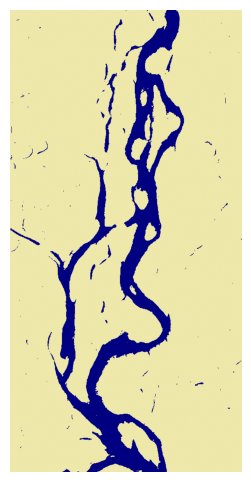

In [27]:
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import ListedColormap

# Specify the sample index, model, dataset, and parameters
sample_img = 0  # Replace with your desired sample index
water_threshold = 0.5
device = 'cuda:0'  # Change to 'cpu' if not using a GPU

# Ensure the input has the correct shape (N, C, T, H, W)
input_img = test_set[sample_img][0].unsqueeze(0).to(device)  # Add batch dimension
target_img = test_set[sample_img][1].cpu()  # Ground truth image (target)

# Get model prediction
with torch.no_grad():
    prediction = model(input_img).detach().cpu()  # Shape: (N, C, H, W)

# Binary thresholding
prediction_binary = (prediction >= water_threshold).float()

# Set up figure
fig, ax = plt.subplots(figsize=(6, 6))

# Custom colormap
grey_cmap = ListedColormap(['palegoldenrod', 'navy'])  # For binary river images

# Plot prediction
ax.imshow(prediction_binary.squeeze(0).squeeze(0), cmap=grey_cmap)

# Show the plot
plt.axis('off')
plt.savefig('prediction.jpeg', dpi=400, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
